# Download the Data

In [142]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('smallcap.csv')  # Make sure to replace '/path/to/your/smallcap.csv' with the actual file path

# Extract the tickers into a list
tickers = df['Symbol'].tolist()

# Now, 'tickers' contains all the tickers from the "Symbol" column of your CSV file
print(tickers)


['BMR', 'GKIN', 'OMH', 'MRAI', 'FLES', 'DKL', 'BNZI', 'GROM', 'OCTO', 'QTI', 'UK', 'HSCS', 'NBCO', 'MCOM', 'AGRI', 'BREA', 'HOLO', 'NXU', 'VLCN', 'HQGE', 'REBN', 'LTRN', 'SPRC', 'LYT', 'OCEA', 'RVSN', 'SMX', 'ASTI', 'AULT', 'APM', 'NKGN', 'CSTF', 'CERO', 'IVP', 'MIRA', 'SIRC', 'AIMD', 'SGD', 'PBM']


In [220]:
import requests
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from datetime import datetime, timedelta


# Replace 'YOUR_API_KEY' with your actual Alpha Vantage API key
api_key = 'HGLDEL3XDK78QXPN'
symbol = 'IBM'  # Example symbol
interval = '5min'  # Data interval
outputsize = 'full'  # Get the full intraday data for a specific month
ts = TimeSeries(key=api_key, output_format='pandas')

tickers = [ 'GKIN', 'OMH', 'MRAI', 'FLES', 'DKL', 'BNZI', 'GROM', 'OCTO', 'QTI', 'UK', 'HSCS', 'NBCO', 'MCOM', 'AGRI', 'BREA', 'HOLO', 'NXU', 'VLCN', 'HQGE', 'REBN', 'LTRN', 'SPRC', 'LYT', 'OCEA', 'RVSN', 'SMX', 'ASTI', 'AULT', 'APM', 'NKGN', 'CSTF', 'CERO', 'IVP', 'MIRA', 'SIRC', 'AIMD', 'SGD', 'PBM']

# Function to generate the past 12 months in 'YYYY-MM' format
def generate_past_12_months():
    return [(datetime.now() - timedelta(days=30*i)).strftime('%Y-%m') for i in range(0, 13)]

# Generate the list of the past 12 months
months = generate_past_12_months()

success_list = []

for ticker in tickers:

    # Initialize a DataFrame to store all the data
    all_data_df = pd.DataFrame()
    results = []
    symbol=ticker

    print(f"Downloading daily data for {ticker} for the full history")
    try:
        # Get daily data
        daily_data, _ = ts.get_daily(symbol=ticker, outputsize='full')
        daily_data.sort_index(ascending=True, inplace=True)
        daily_data.index = pd.to_datetime(daily_data.index)
    except Exception as e:
        print(f"Error for {ticker}: {e}")

    print(f"Downloading intraday data for {ticker} for the past year")

    # Calculate the slices for the past 12 months from the current date
    for month in months[::-1]:
    # for month in ['2024-02']:
        # if daily volume is too low, skip this one

        try:
            url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&month={month}&outputsize={outputsize}&apikey={api_key}'
            response = requests.get(url)
            data = response.json()  # Data is in JSON format

            # The exact key for the time series data depends on the interval and function used
            # Adjust the key based on the actual structure of your JSON response
            time_series_key = f"Time Series ({interval})"

            if time_series_key in data:
                time_series_data = data["Time Series (5min)"]
                # Convert to DataFrame
                df = pd.DataFrame.from_dict(time_series_data, orient='index')
                df.index = pd.to_datetime(df.index)  # Converting index to datetime
                df.sort_index(inplace=True)  # Sorting by datetime index

                # Concatenate with the main DataFrame
                all_data_df = pd.concat([all_data_df, df])

            else:
                print(f"No data found for month: {month}")
                break

            for day in pd.unique(df.index.date):
                day_str = day.strftime('%Y-%m-%d')
                day_data = all_data_df.between_time('09:30', '10:30').loc[day_str]
                if not day_data.empty:
                    open_price  = float(day_data.iloc[0]['1. open'])
                    close_price = float(day_data.iloc[-1]['4. close'])
                    high_price  = float(day_data['2. high'].max())
                    low_price   = float(day_data['3. low'].min())

                    # Find the last trading day's close price
                    today_open = daily_data.loc[day_str,'1. open']
                    previous_days_data = daily_data[daily_data.index < day_str]

                    # Calculate the gap percentage compared to yesterday's close
                    if not previous_days_data.empty:
                        previous_day_close   = previous_days_data.iloc[-1]['4. close']
                        previous_day_open    = previous_days_data.iloc[-1]['1. open']
                        previous_day_high    = previous_days_data.iloc[-1]['2. high']
                        previous_day_low     = previous_days_data.iloc[-1]['3. low']
                        previous_day_volume  = previous_days_data.iloc[-1]['5. volume']

                        two_days_ago_close = previous_days_data.iloc[-2]['4. close']
                        two_days_ago_open = previous_days_data.iloc[-2]['1. open']
                        two_days_ago_high = previous_days_data.iloc[-2]['2. high']
                        two_days_ago_low  = previous_days_data.iloc[-2]['3. low']
                        two_days_ago_volume = previous_days_data.iloc[-2]['5. volume']

                        # print(type(previous_day_close), type(open_price))
                        gap_percentage = ((today_open - previous_day_close) / previous_day_close) * 100
                    else:
                        gap_percentage = None

                    results.append([day, ticker, open_price, close_price, high_price, low_price, gap_percentage, previous_day_close, previous_day_open, previous_day_high, previous_day_low, previous_day_volume, two_days_ago_close, two_days_ago_open, two_days_ago_high, two_days_ago_low, two_days_ago_volume])

        except Exception as e:
            print(f"Error for {ticker}: {e}")

    # # # Convert the results into a DataFrame with an additional column for the gap percentage
    results_df = pd.DataFrame(results, columns=['Date', 'Ticker', '9:30 Price', '10:30 Price', 'High Price', 'Low Price', 'Gap Percentage', 'previous_day_close',  'previous_day_open', 'previous_day_high', 'previous_day_low', 'previous_day_volume', 'two_days_ago_close', 'two_days_ago_open', 'two_days_ago_high', 'two_days_ago_low', 'two_days_ago_volume'])

    results_df.to_csv(f'{ticker}.csv', index=False)
    if not results_df.empty:
        success_list.append(ticker)
        print(f'---> Data retrival successful for {ticker}')

No data found for month: 2023-03
Error for OMH: '2023-03-21'
---> Data retrival successful for OMH
---> Data retrival successful for MRAI
No data found for month: 2023-03
---> Data retrival successful for DKL
No data found for month: 2023-03
---> Data retrival successful for GROM
---> Data retrival successful for OCTO
No data found for month: 2023-03
---> Data retrival successful for UK
---> Data retrival successful for HSCS
No data found for month: 2023-03
Error for MCOM: '2023-03-01'
Error for MCOM: '2023-04-03'
Error for MCOM: '2023-05-01'
Error for MCOM: '2023-06-01'
Error for MCOM: '2023-07-03'
Error for MCOM: '2023-08-01'
Error for MCOM: '2023-09-01'
Error for MCOM: '2023-10-02'
Error for MCOM: '2023-11-01'
Error for MCOM: '2023-12-01'
No data found for month: 2024-01
---> Data retrival successful for AGRI
Error for BREA: '2023-04-28'
Error for BREA: '2023-12-29'
---> Data retrival successful for BREA
---> Data retrival successful for HOLO
Error for NXU: '2023-03-01'
Error for NX

In [219]:
# print(day_data)
print(all_data_df)
# print(day_data.at_time('10:00').iloc[0]['1. open'])

                    1. open 2. high  3. low 4. close 5. volume
2024-02-01 07:40:00  1.1000  1.1000  1.1000   1.1000         2
2024-02-01 07:55:00  1.1800  1.1800  1.1700   1.1700       150
2024-02-01 08:00:00  1.1200  1.1200  1.1200   1.1200        15
2024-02-01 08:35:00  1.1900  1.1900  1.1900   1.1900        36
2024-02-01 08:55:00  1.1500  1.1500  1.1500   1.1500         3
...                     ...     ...     ...      ...       ...
2024-03-08 19:35:00  1.5200  1.5200  1.5200   1.5200         1
2024-03-08 19:40:00  1.5110  1.5110  1.5110   1.5110       100
2024-03-08 19:45:00  1.5200  1.5400  1.5200   1.5200      1300
2024-03-08 19:50:00  1.5200  1.5200  1.5200   1.5200         1
2024-03-08 19:55:00  1.5200  1.5200  1.5100   1.5100       713

[2354 rows x 5 columns]


# Analyze the Data

Occurrences where gap up is between 20% and 300%: 93
Distribution of price change between 9:30 to 10:30:
count    93.000000
mean     -8.307547
std      14.723287
min     -44.488978
25%     -16.112758
50%     -11.442464
75%      -2.857143
max      33.244681
Name: IntradayChangePct, dtype: float64
Percentage of price drops: 79.56989247311827%



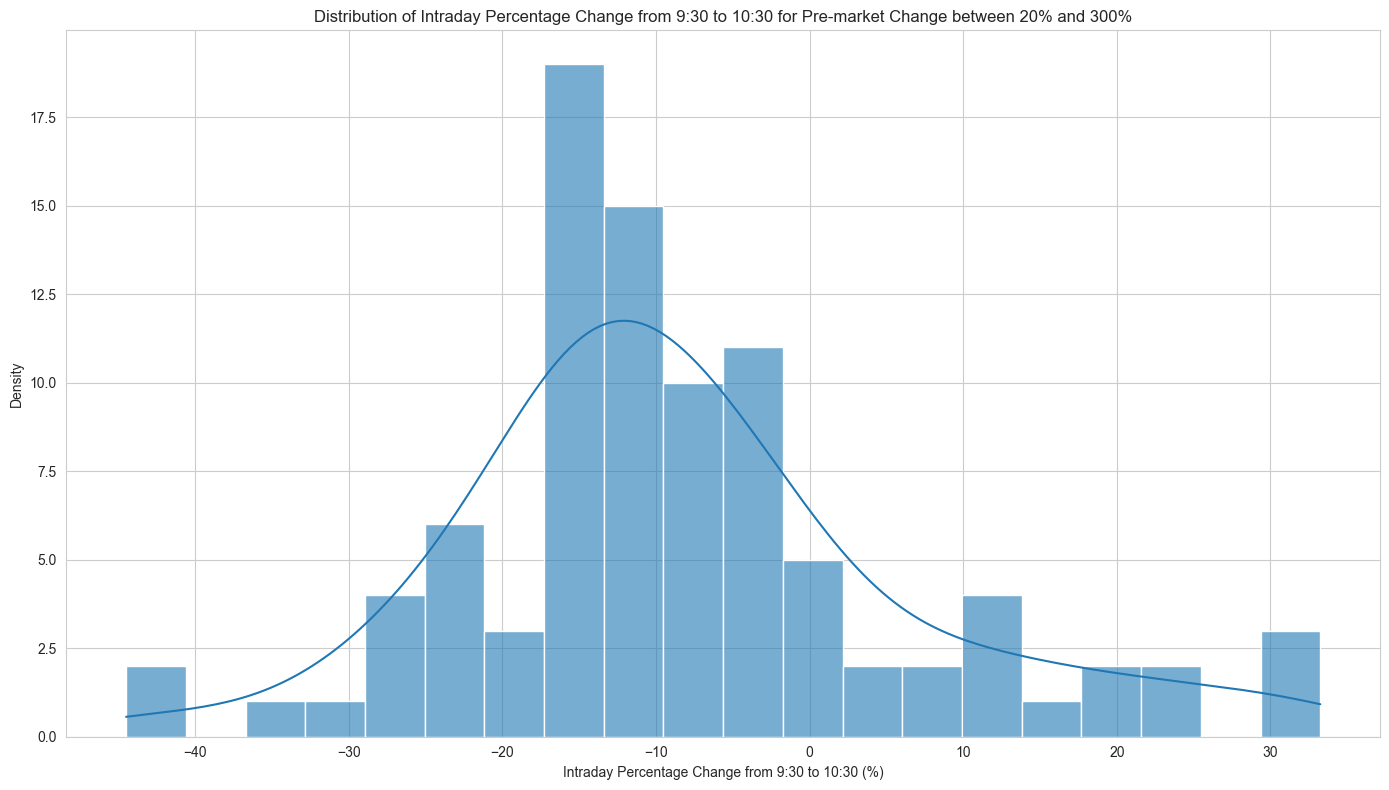

Percentage of monotonic decreasing within 5%: 36.55913978494624



In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_gap_movement(success_list, csv_path, gap_threshold, gap_cap):
    # Initialize a DataFrame to store all filtered data
    gap_data = pd.DataFrame()

    # Iterate through each ticker
    for ticker in success_list:
        df = pd.read_csv(f'{csv_path}/{ticker}.csv')

        # Ensure 'Date' is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Filter for days where pre-market change meets the threshold and cap, for this ticker
        if gap_threshold > 0:
            df_filtered = df[(df['Gap Percentage'] > gap_threshold) & (df['Gap Percentage'] < gap_cap)]
        else:
            df_filtered = df[(df['Gap Percentage'] < gap_threshold) & (df['Gap Percentage'] > gap_cap)]

        # Add this ticker's filtered data to the aggregate DataFrame
        gap_data = pd.concat([gap_data, df_filtered])

    # Calculate the 'IntradayChangePct' dynamically
    gap_data['IntradayChangePct'] = ((gap_data['10:30 Price'] - gap_data['9:30 Price']) / gap_data['9:30 Price']) * 100

    # Calculate the distribution of price changes
    price_change_distribution = gap_data['IntradayChangePct'].describe()

    # Determine the percentage of price drops or rises
    if gap_threshold > 0:
        price_drops = gap_data[gap_data['IntradayChangePct'] < 0]
    else:
        price_drops = gap_data[gap_data['IntradayChangePct'] > 0]
    percentage_price_drops = (len(price_drops) / len(gap_data)) * 100 if len(gap_data) > 0 else 0

    # Print the results
    direction = "up" if gap_threshold > 0 else "down"
    print(f"Occurrences where gap {direction} is between {gap_threshold}% and {gap_cap}%: {len(gap_data)}")
    print("Distribution of price change between 9:30 to 10:30:")
    print(price_change_distribution)
    print(f"Percentage of price {('drops' if direction == 'up' else 'rises')}: {percentage_price_drops}%\n")

    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    plt.figure(figsize=(14, 8))
    plt.title(f'Distribution of Intraday Percentage Change from 9:30 to 10:30 for Pre-market Change between {gap_threshold}% and {gap_cap}%')

    # Plot the distribution
    sns.histplot(gap_data['IntradayChangePct'], kde=True, bins=20, alpha=0.6)

    plt.xlabel('Intraday Percentage Change from 9:30 to 10:30 (%)')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

    # check if the price drop is monotonic
    # Initialize counter for monotonic decreasing occurrences
    monotonic_decreasing_count = 0
    price_diff_threshold = 5
    # Loop through the filtered DataFrame
    for index, row in gap_data.iterrows():
        high_price = row['High Price']
        low_price = row['Low Price']
        open_price = row['9:30 Price']
        close_price = row['10:30 Price']

        # Check for decreasing price condition
        if close_price < open_price:
            # Calculate percentage differences
            high_price_diff = ((high_price - open_price) / open_price) * 100
            low_price_diff = ((close_price - low_price) / close_price) * 100

            # Check if within threshold
            if abs(high_price_diff) <= price_diff_threshold:
                # and abs(low_price_diff) <= price_diff_threshold:
                monotonic_decreasing_count += 1
    monotonic_decreasing_ratio = monotonic_decreasing_count/len(gap_data) * 100
    print(f"Percentage of monotonic decreasing within {price_diff_threshold}%: {monotonic_decreasing_ratio}\n")


# Example usage:
csv_path = '.'  # Update this path
gap_threshold = 20  # For gap-up or gap-down analysis
gap_cap = 300  # Upper bound for the gap percentage
analyze_gap_movement(success_list, csv_path, gap_threshold, gap_cap)


Occurrences where gap up is above 50%: 59
Distribution of price change between 9:30 to 10:30:
count    59.000000
mean     -7.277261
std      16.478742
min     -44.488978
25%     -16.076923
50%      -7.692308
75%       1.274091
max      33.244681
Name: IntradayChangePct, dtype: float64
Percentage of price drops: 72.88135593220339%



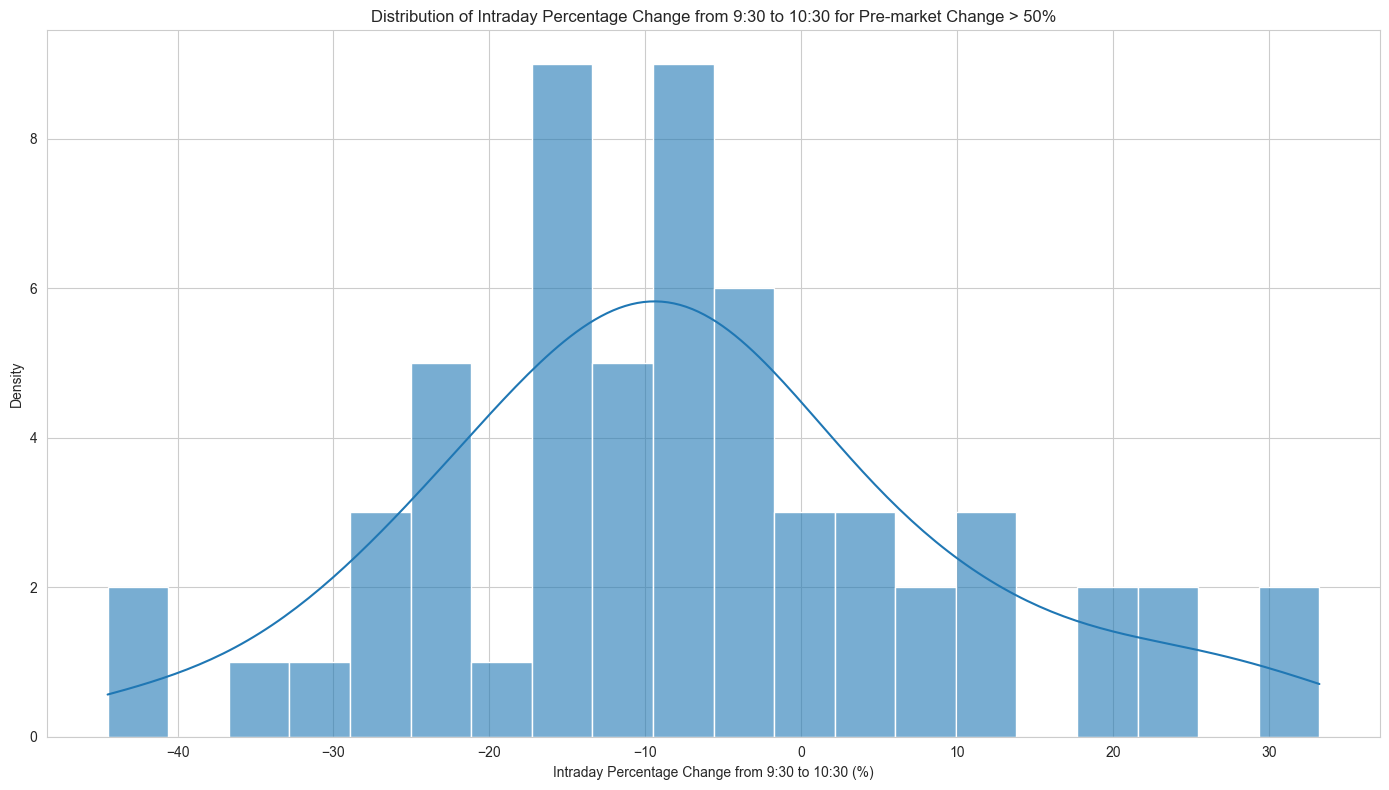

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_gap_movement(success_list, csv_path, gap_threshold):
    # Initialize a DataFrame to store all filtered data
    gap_data = pd.DataFrame()

    # Iterate through each ticker
    for ticker in success_list:
        df = pd.read_csv(f'{csv_path}/{ticker}.csv')

        # Ensure 'Date' is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Filter for days where pre-market change meets the threshold, for this ticker
        if gap_threshold > 0:
            df_filtered = df[df['Gap Percentage'] > gap_threshold]
        else:
            df_filtered = df[df['Gap Percentage'] < gap_threshold]
        
        # Add this ticker's filtered data to the aggregate DataFrame
        gap_data = pd.concat([gap_data, df_filtered])

    # Calculate the 'IntradayChangePct' dynamically
    gap_data['IntradayChangePct'] = ((gap_data['10:30 Price'] - gap_data['9:30 Price']) / gap_data['9:30 Price']) * 100

    # Calculate the distribution of price changes
    price_change_distribution = gap_data['IntradayChangePct'].describe()

    # Determine the percentage of price drops (negative price change for gap up, positive for gap down)
    if gap_threshold > 0:
        price_drops = gap_data[gap_data['IntradayChangePct'] < 0]
    else:
        price_drops = gap_data[gap_data['IntradayChangePct'] > 0]
    
    percentage_price_drops = (len(price_drops) / len(gap_data)) * 100 if len(gap_data) > 0 else 0

    # Print the results
    direction = "up" if gap_threshold > 0 else "down"
    print(f"Occurrences where gap {direction} is above {abs(gap_threshold)}%: {len(gap_data)}")
    print("Distribution of price change between 9:30 to 10:30:")
    print(price_change_distribution)
    print(f"Percentage of price {('drops' if direction == 'up' else 'rises')}: {percentage_price_drops}%\n")

    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    plt.figure(figsize=(14, 8))
    plt.title(f'Distribution of Intraday Percentage Change from 9:30 to 10:30 for Pre-market Change > {abs(gap_threshold)}%')

    # Plot the distribution
    sns.histplot(gap_data['IntradayChangePct'], kde=True, bins=20, alpha=0.6)

    plt.xlabel('Intraday Percentage Change from 9:30 to 10:30 (%)')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

# Example usage:
# success_list = ['Ticker1', 'Ticker2']  # Replace with your actual tickers
csv_path = '.'  # Update this path
gap_threshold = 50  # Positive for gap-up, negative for gap-down analysis
analyze_gap_movement(success_list, csv_path, gap_threshold)


In [ ]:
import pandas as pd

# Assuming 'all_filtered_data' is your DataFrame and it's already loaded with necessary columns

# Loop through each ticker
for ticker in success_list:
    
    df = pd.read_csv(f'{ticker}.csv')

    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter data for this ticker where gap up is above 20%
    ticker_data = df[(df['Ticker'] == ticker) & (all_filtered_data['Gap Percentage'] > 20)]

    # Calculate price change between 9:30 to 10:30
    ticker_data['Price Change 9:30-10:30'] = ticker_data['10:30 Price'] - ticker_data['9:30 Price']

    # Calculate the distribution of price changes
    price_change_distribution = ticker_data['Price Change 9:30-10:30'].describe()

    # Determine the percentage of price drops (negative price change)
    price_drops = ticker_data[ticker_data['Price Change 9:30-10:30'] < 0]
    percentage_price_drops = (len(price_drops) / len(ticker_data)) * 100 if len(ticker_data) > 0 else 0

    # Print the results
    print(f"Ticker: {ticker}")
    print(f"Occurrences where gap up is above 20%: {len(ticker_data)}")
    print("Distribution of price change between 9:30 to 10:30:")
    print(price_change_distribution)
    print(f"Percentage of price drops: {percentage_price_drops}%\n")


Occurrences where gap up is above 20%: 33
Distribution of price change between 9:30 to 10:30:
count    33.000000
mean     -7.159610
std      18.709666
min     -44.488978
25%     -17.123288
50%      -7.668712
75%       2.768362
max      33.244681
Name: IntradayChangePct, dtype: float64
Percentage of price drops: 69.6969696969697%



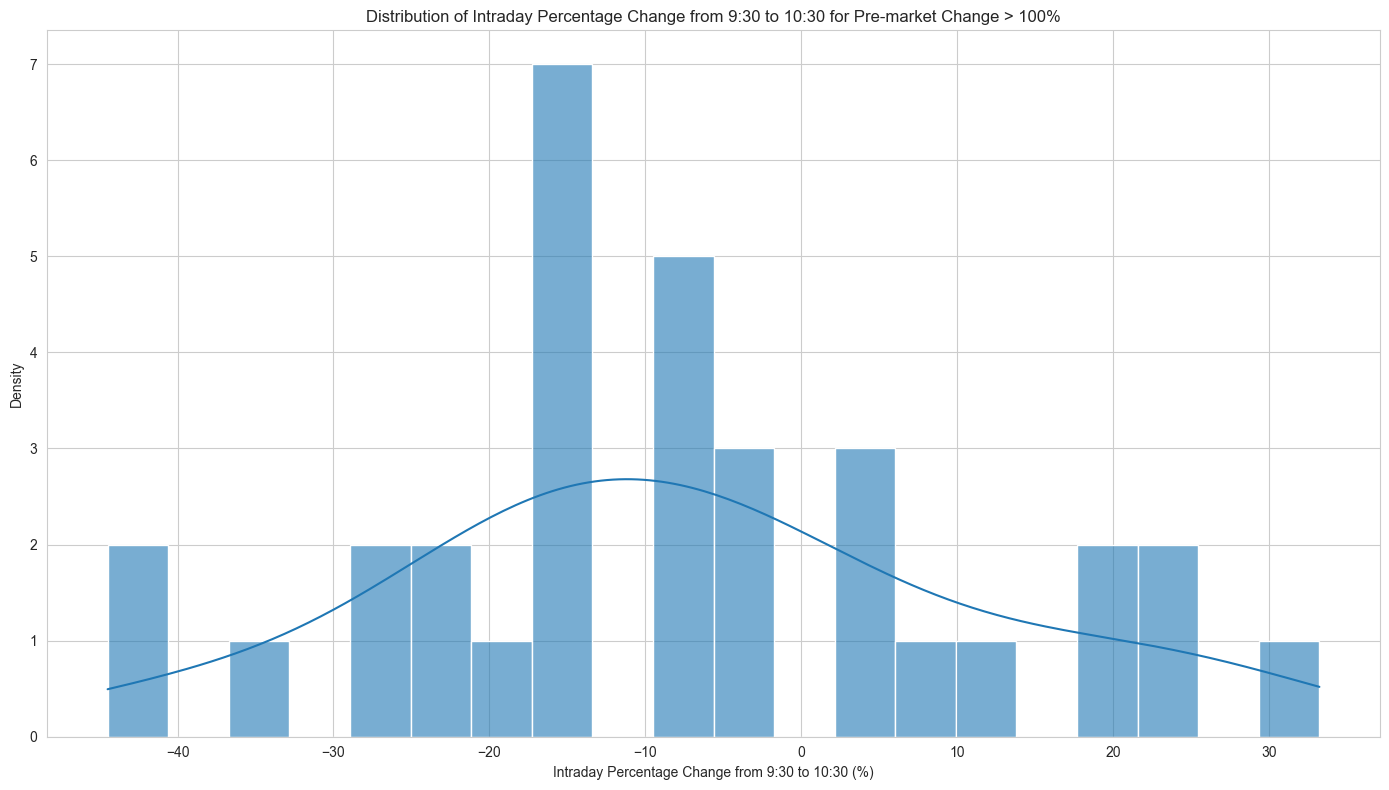

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a DataFrame to store all filtered data
gap_up_data = pd.DataFrame()
gap_down_data = pd.DataFrame()

# Iterate through each ticker
price_moved_down = 0

for ticker in success_list:
    df = pd.read_csv(f'{ticker}.csv')

    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter for days where pre-market change > 20%, for this ticker
    df_filtered = df[df['Gap Percentage'] > 100]
    # Add this ticker's filtered data to the aggregate DataFrame
    gap_up_data = pd.concat([gap_up_data, df_filtered])

    # Filter for days where pre-market change > 20%, for this ticker
    df_filtered = df[df['Gap Percentage'] < -20]
    # Add this ticker's filtered data to the aggregate DataFrame
    gap_down_data = pd.concat([gap_down_data, df_filtered])

# Calculate the 'IntradayChangePct' dynamically
gap_up_data['IntradayChangePct'] = ((gap_up_data['10:30 Price'] - gap_up_data['9:30 Price']) / gap_up_data['9:30 Price']) * 100
gap_down_data['IntradayChangePct'] = ((gap_down_data['10:30 Price'] - gap_down_data['9:30 Price']) / gap_down_data['9:30 Price']) * 100

# Calculate the distribution of price changes
price_change_distribution = gap_up_data['IntradayChangePct'].describe()

# Determine the percentage of price drops (negative price change)
price_drops = gap_up_data[gap_up_data['IntradayChangePct'] < 0]
percentage_price_drops = (len(price_drops) / len(gap_up_data)) * 100 if len(gap_up_data) > 0 else 0

# Print the results
print(f"Occurrences where gap up is above 20%: {len(gap_up_data)}")
print("Distribution of price change between 9:30 to 10:30:")
print(price_change_distribution)
print(f"Percentage of price drops: {percentage_price_drops}%\n")

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(14, 8))
plt.title('Distribution of Intraday Percentage Change from 9:30 to 10:30 for Pre-market Change > 100%')

# Plot the distribution for each ticker
# for ticker in gap_up_data['Ticker'].unique():
sns.histplot(gap_up_data['IntradayChangePct'], kde=True, label=ticker, bins=20, alpha=0.6)

plt.xlabel('Intraday Percentage Change from 9:30 to 10:30 (%)')
plt.ylabel('Density')
# plt.legend(title='Ticker')
plt.tight_layout()
plt.show()


In [126]:
print(df)

                      1. open   2. high    3. low  4. close 5. volume
2024-03-01 04:15:00  185.4600  185.4600  185.4600  185.4600         2
2024-03-01 04:25:00  185.4700  185.4700  185.4600  185.4600         2
2024-03-01 04:30:00  185.0600  185.4600  185.0600  185.4600         2
2024-03-01 04:35:00  185.4500  185.4500  185.4500  185.4500         1
2024-03-01 04:45:00  185.0900  185.0900  185.0900  185.0900        71
...                       ...       ...       ...       ...       ...
2024-03-08 19:35:00  196.2300  196.2300  196.2300  196.2300         2
2024-03-08 19:40:00  195.4900  195.9400  195.4900  195.9400         8
2024-03-08 19:45:00  195.9500  195.9500  195.4900  195.5000        32
2024-03-08 19:50:00  195.5000  195.5000  195.5000  195.5000         3
2024-03-08 19:55:00  195.4900  195.4900  195.4800  195.4800       105

[1072 rows x 5 columns]
